<a href="https://colab.research.google.com/github/nafisegh/ViT_Methane_Plume_Detection/blob/main/ViT_Methane_Plume_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision einops

In [2]:
import google
import shutil
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from einops import rearrange
import matplotlib.pyplot as plt


In [3]:
google.colab.drive.mount('/content/drive/')

shutil.unpack_archive('/content/drive/MyDrive/ViT_Methane_Plume_Detection/Dataset.zip', '/content/drive/MyDrive/ViT_Methane_Plume_Detection')

os.chdir('/content/drive/MyDrive/ViT_Methane_Plume_Detection')

transform = transforms.Compose([
    transforms.Resize((512,512)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
#train_data = datasets.CIFAR10(root='/.data',train=True, download=True, transform=transform)
#test_data = datasets.CIFAR10(root='/.data', train=False, download=True, transform=transform)
train_data = datasets.ImageFolder(root='Dataset/train', transform=transform)
val_data = datasets.ImageFolder(root='Dataset/val', transform=transform)
test_data = datasets.ImageFolder(root='Dataset/test', transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
class PatchEmbedding(nn.Module):
      def __init__(self, in_channels=3, patch_size=64, emb_size=64, img_size=32):
        super().__init__()
        self.projection = nn.Conv2d(in_channels, emb_size,
                                    kernel_size=patch_size, stride=patch_size)
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))
        self.pos_embedding = nn.Parameter(torch.randn(1, (img_size//patch_size)**2+1, emb_size))

      def forward(self,x):

        B = x.shape[0]
        x = self.projection(x)
        x = x.flatten(2).transpose(1,2)
        cls_token = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = x + self.pos_embedding
        return x

In [5]:
class TransformerEncoder(nn.Module):
  def __init__(self, emb_size=64, num_heads=4, mlp_ratio=4, dropout=0.1):
    super().__init__()
    self.norm1 =nn.LayerNorm(emb_size)
    self.atten = nn.MultiheadAttention(emb_size, num_heads, dropout, batch_first=True)
    self.norm2 =nn.LayerNorm(emb_size)
    self.mlp = nn.Sequential(
        nn.Linear(emb_size, int(emb_size * mlp_ratio)),
        nn.GELU(),
        nn.Dropout(dropout),
        nn.Linear(int(emb_size * mlp_ratio), emb_size),
        nn.Dropout(dropout)

    )
  def forward(self,x):
      x = x + self.atten(self.norm1(x), self.norm1(x), self.norm1(x))[0]
      x = x + self.mlp(self.norm2(x))
      return x

In [6]:
class ViT(nn.Module):
  def __init__(self, img_size=32, patch_size=64, emb_size=64, depth=4, num_heads=4, num_classes=2):
    super().__init__()
    self.patch_embed= PatchEmbedding(3, patch_size, emb_size, img_size)
    self.encoder = nn.Sequential(*[TransformerEncoder(emb_size, num_heads) for _ in range(depth)])
    self.norm = nn.LayerNorm(emb_size)
    self.fc = nn.Linear(emb_size, num_classes)

  def forward(self, x):
    x = self.patch_embed(x)
    x = self.encoder(x)
    x = self.norm(x)
    cls_token = x[:,0]

    return self.fc(cls_token)


In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ViT().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

for epoch in range(150):
  model.train()
  train_loss = 0
  train_correct = 0
  for imgs, labels in train_loader:

    imgs, labels = imgs.to(device), labels.to(device)
    outputs = model(imgs)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.item() * imgs.size(0)
    _, preds = torch.max(outputs, 1)
    train_correct += (preds == labels).sum().item()

  #__VALIDATION_PHASE__
  model.eval()
  val_loss = 0
  val_correct = 0
  with torch.no_grad():
    for imgs,labels in val_loader:

      imgs, labels = imgs.to(device), labels.to(device)
      outputs = model(imgs)
      loss = criterion(outputs, labels)
      val_loss += loss.item() * imgs.size(0)
      _, preds = torch.max(outputs, 1)
      val_correct += (preds == labels).sum().item()

  train_acc = train_correct / len(train_loader)
  val_acc = val_correct / len(val_loader)
  print(f"Epoch {epoch+1} | Train Loss: {train_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(val_loader):.4f}")
  print(f"Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")

Epoch 1 | Train Loss: 43.6602, Validation Loss: 42.1390
Train Accuracy: 31.6667, Validation Accuracy: 27.2500
Epoch 2 | Train Loss: 42.4951, Validation Loss: 41.7335
Train Accuracy: 32.7619, Validation Accuracy: 33.2500
Epoch 3 | Train Loss: 42.3630, Validation Loss: 41.6403
Train Accuracy: 32.8095, Validation Accuracy: 33.2500
Epoch 4 | Train Loss: 42.3335, Validation Loss: 41.6227
Train Accuracy: 32.9524, Validation Accuracy: 33.2500
Epoch 5 | Train Loss: 42.4410, Validation Loss: 41.6253
Train Accuracy: 33.3333, Validation Accuracy: 33.2500
Epoch 6 | Train Loss: 42.3858, Validation Loss: 41.7607
Train Accuracy: 33.0000, Validation Accuracy: 33.2500
Epoch 7 | Train Loss: 42.5115, Validation Loss: 41.8811
Train Accuracy: 33.1905, Validation Accuracy: 36.0000
Epoch 8 | Train Loss: 42.1785, Validation Loss: 41.5420
Train Accuracy: 33.4286, Validation Accuracy: 33.2500
Epoch 9 | Train Loss: 42.1493, Validation Loss: 41.4517
Train Accuracy: 33.8095, Validation Accuracy: 34.2500
Epoch 10 |

In [8]:
torch.save(model, "plume_model_AdamW_Epoch_150_lr_e-4.pth")

In [9]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
  for imgs, labels in test_loader:
    imgs, labels = imgs.to(device), labels.to(device)
    preds = model(imgs)
    _, predicted = preds.max(1)
    total +=labels.size(0)
    correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {100* correct/total:.2f}%")


Test Accuracy: 98.67%


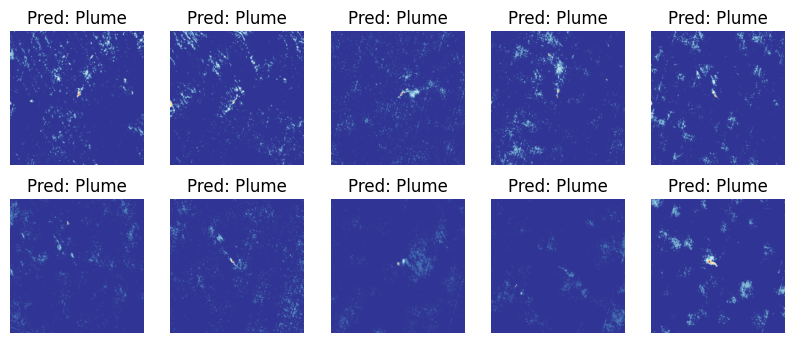

In [20]:
data_iter = iter(test_loader)
images, labels = next(data_iter)
outputs = model (images.to(device))
_, preds = torch.max(outputs, 1)

fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for i, ax in enumerate(axes.flat):
  ax.imshow(images[i].permute(1,2,0)*0.5 + 0.5)
  if preds[i].item()==0:
    ax.set_title("Pred: Plume")
  else:
    ax.set_title("Pred: Plume Free")

  ax.axis('off')

plt.show()



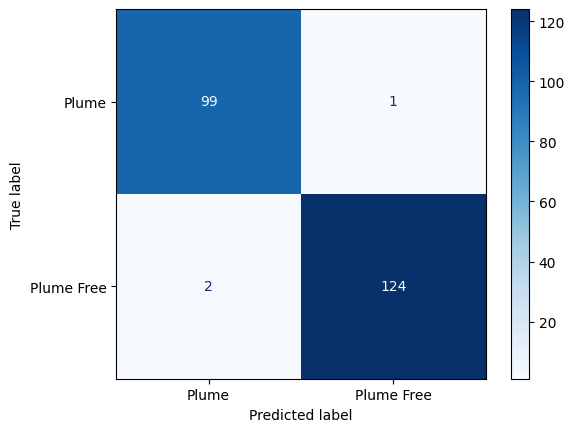

In [19]:
from IPython.testing import test
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

test_labels = []
test_preds = []

for images, labels in test_loader:
  images, labels = images.to(device), labels.to(device)
  outputs = model(images)
  _, preds = torch.max(outputs,1)
  test_labels.extend(labels.cpu().numpy())
  test_preds.extend(preds.cpu().numpy())

cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Plume','Plume Free'])
disp.plot(cmap=plt.cm.Blues)
plt.show()